# Accelerate Notebook: Accelerating hit acquisition in drug screening

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1)
sns.set()

In [3]:
# Read in data
df = pd.read_csv('Data/Docker.csv')

In [4]:
#remove unneeded columns
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8978 entries, 0 to 8977
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    8978 non-null   object 
 1   Score     8978 non-null   float64
 2   Feature   8978 non-null   object 
 3   Docker_0  8978 non-null   float64
 4   Docker_1  8978 non-null   float64
 5   Docker_2  8978 non-null   float64
 6   Docker_3  8978 non-null   float64
dtypes: float64(5), object(2)
memory usage: 491.1+ KB


## Description of df Contents
- a SMILES representation: A string representation of a molecule, one of the most common methods used to represent a molecule in 2 dimensions
- a score: obtained from AutoDock Vina, a docking algorithm that predicts binding energies between molecules and proteins
- a feature: jtnn-autoencoder representation of all of the molecules that will be used later
- Tanimoto similarity of 4 known molecular structures (0=no structural similarity, 1=identical structures), Docker_0 being one of these structures and the associated data being all of the subsequent molecules' similarities to that structure

In [6]:
df.columns

Index(['SMILES', 'Score', 'Feature', 'Docker_0', 'Docker_1', 'Docker_2',
       'Docker_3'],
      dtype='object')

## Import required rdkit modules to obtain Morgan fingerprints and Tanimoto Similarity

 - Morgan fingerprints are one of the most commonly used numerical representations of molecules (albeit fairly crude ones)
 - Tanimoto similarity is a value between 0 and 1 giving the similarity between two Morgan fingerprints as explained above

In [7]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

rdkit.__version__


'2020.09.5'

,SMILES,Score,Feature,Docker_0,Docker_1,Docker_2,Docker_3,ROMol
0,C1=CC=C2C(=C1)C(=O)C3=CC=CC=C3O2,-6.7,"[0.4072841703891754, -1.0260746479034424, 0.29...",0.318182,0.116667,0.127273,0.211538,

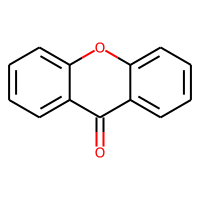

In [8]:
# Convert SMILES into RDKit Mol representation and append to dataframe

from rdkit.Chem import PandasTools

PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES')
df.head(1)

In [9]:
# Convert RDKit Mol representation into Morgan fingerprint and append to dataframe

radius = 2
nBits = 1024

df['Morgan'] = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in df['ROMol']]

In [10]:
# Check shape is appropriate
np.array(df['Morgan'][0]).shape

(1024,)

## Obtain Tanimoto Similarity

The following function takes a structure label (any string you want to use to refer to your structure) the SMILES string representation of the molecule, and a dataframe with a column called 'Morgan' containing the Morgan fingerprint representations of the molecules you wish to compare your original structure to. 

Note: this is meant to illustrate how to obtain a Tanimoto similarity measure, uncommenting and running the loop will attach a 9000x9000 grid to your spreadsheet containing all the similarity measures between every molecule and every other molecule


In [11]:
from rdkit import DataStructs
from rdkit.Chem import PandasTools

def Tanimoto(label, smile_string, df, radius=2, nBits=1024):
    RDMol = Chem.MolFromSmiles(smile_string)
    Morgan = AllChem.GetMorganFingerprintAsBitVect(RDMol, radius=radius, nBits=nBits)
    df[f'Tanimoto_{str(label)}'] = [DataStructs.FingerprintSimilarity(Morgan, x) for x in df['Morgan']]
    return df


#following loop gives the similarity of every structure to every other sructure 

# strings = pd.DataFrame(df['SMILES'])
# for entry in range(0, len(df)):
#     Tanimoto(f'{entry}_', strings.iloc[entry, 0], df)


,SMILES,Score,Feature,Docker_0,Docker_1,Docker_2,Docker_3,ROMol,Morgan
0,C1=CC=C2C(=C1)C(=O)C3=CC=CC=C3O2,-6.7,"[0.4072841703891754, -1.0260746479034424, 0.29...",0.318182,0.116667,0.127273,0.211538,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

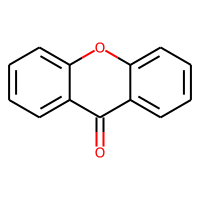

In [12]:
# Check that it has worked as expected
df.head(1)

### Save to csv

In [13]:
# Remove ROMol, memory intensive
df.drop(columns = ['ROMol'], inplace=True)

In [14]:
# Convert Morgan to list for easier string manipulation when the csv is read again
df['Morgan'] = df['Morgan'].apply(lambda x: list(np.array(x)))

In [15]:
df.to_csv('Data/Docker_Morgan_Fingerpint.csv')

## Investigate the Scoring distribution 

In [16]:
# read in csv

df = pd.read_csv('Data/Docker_Morgan_Fingerpint.csv')
df.drop('Unnamed: 0', inplace = True, axis=1)
len(df)

8978

<AxesSubplot:ylabel='Score'>

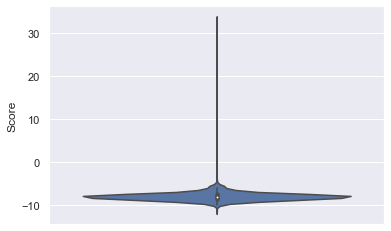

In [17]:
# In this case the score is a measure of binding energy and so the more negative the better
sns.violinplot(y = 'Score', data = df)

In [18]:
# Remove molecules with positive binding energies (simulation yields one molecule with a score of +30)
df_outliers = df[df['Score'] > 0]
df = df[df['Score'] < 0]
len(df)

8977

<AxesSubplot:ylabel='Score'>

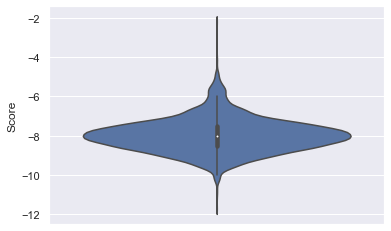

In [19]:
sns.violinplot(y = 'Score', data = df)

## PCA, kmeans and DBSCAN on features (both Morgan fingerprint and alternative representation obtained from a jtnn-autoencoder)

The following section is meant to investigate how well clustering algorithms can separate the molecular representations (both the Morgan Fingerprints and the Feature derived from the jtnn-autoencoder), and this is then compared with 'real' clustering of the molecules into 4 groups based on their similarity to the 4 docker strucures in the original df

The following steps are taken:
- PCA to reduce dimensionality across the molecule representations to see if we can get a broad view of what is occurring (this does not work especially well for Morgan Fingerprints as there is a great deal of unexplained variance, but works a little better for the jtnn-autoencoder features)
- kmeans clustering with 4 centres on the Morgan fingerprints, and comparison with 4 'real' clustering labels, the grouping of molecules depending on whether they are most similar to Docker_0, Docker_1, Docker_3 and Docker_4. NOTE: the numeric labelling for the clustering refers to Docker_0, Docker_1 etc, while that for the kmeans clustering is simply an arbitrary label of the cluster so the labels are not cross comparable)
- DBSCAN on the same data (note this approach performs very poorly)
- The whole above process is repeated again for the jtnn-autoencoder features

In [20]:
# Converts string into list of floats
def str_to_list(string):
    string = string.strip('][').split(', ')
    string2 = []
    for entry in string:
        string2.append(float(entry))
    return string2


In [21]:
# Begin investigation of Fingerprint clustering, to see if there is any crossover between real and predicted labels

feature = 'Morgan' 
df['Feat_list'] = df[feature].apply(str_to_list)

In [22]:
X = list(df['Feat_list'])
X = np.array(X)

y = np.array(list(df['Score']))


In [23]:
print(X.shape, y.shape)


(8977, 1024) (8977,)


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.fit_transform(X)


This function takes in a feature set X, a label y_pred and a string for the title. It then graphs principal
components 1, 2, 3 and 4 from a PCA of the features colour coded according to the cluster labels y_pred. In the first instance y_pred is the kmeans clustering label and then later on a 'real' clustering label is used for comparison.

The function also prints out the explained variance of each of the principal components in number order, 0 meaning no variance explained and 1 meaning all of the variance explained.

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def graph_pca(X, y_pred, title):
    pca = PCA(n_components=4)
    principalComponents = pca.fit_transform(X)
    print(pca.explained_variance_ratio_)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1',
                              'principal component 2',
                              'principal component 3',
                              'principal component 4'])
    finalDf = principalDf.copy()
    finalDf['y_pred'] = y_pred


    #graph PC1 and PC2

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(f'2 component PCA, {title}', fontsize = 20)
    targets = [0, 1, 2, 3]
    colors = ['y', 'r', 'g', 'b']

    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['y_pred'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                    , finalDf.loc[indicesToKeep, 'principal component 2']
                    , c = color
                    , s = 50)
    ax.legend(targets)
    ax.grid()
    
    #graph PC3 and PC4

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 3', fontsize = 15)
    ax.set_ylabel('Principal Component 4', fontsize = 15)
    ax.set_title(f'2 component PCA, {title}', fontsize = 20)
    targets = [0, 1, 2, 3]
    colors = ['y', 'r', 'g', 'b']
    
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['y_pred'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 3']
                   , finalDf.loc[indicesToKeep, 'principal component 4']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

    


[0.02755854 0.01694142 0.01174674 0.01000988]


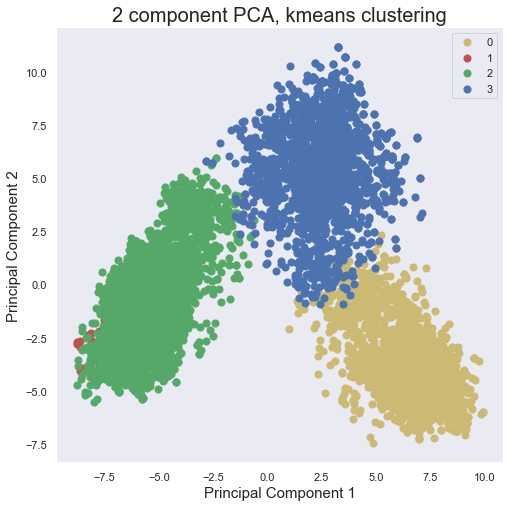

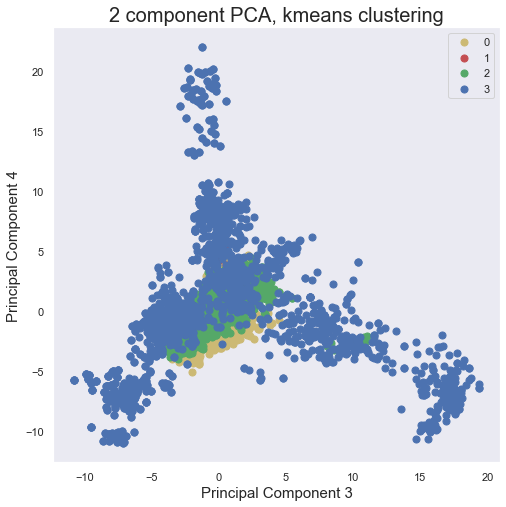

In [26]:
# Predicted kmeans clustering on fingerprints, PCAs explain v little of the overall variance for Morgan Fingerprints
y_pred = KMeans(n_clusters=4, random_state=0).fit_predict(X)
graph_pca(X, y_pred, 'kmeans clustering')

Compare with real clustering (similarity to 4 known structures), the functions in the cell below use the Tanimoto similarity measures to Dockers_0/1/2/3 to add a label column to the df which groups the molecules according to which structure they are most similar to



In [27]:
def parent_0(lst):
    if lst > 0.3:
        x = '0'
        return x
    
def parent_1(lst):
    if lst > 0.3:
        x = '1'
        return x

def parent_2(lst):
    if lst > 0.3:
        x = '2'
        return x

def parent_3(lst):
    if lst > 0.3:
        x = '3'
        return x
    
    

df['0'] = df['Docker_0'].apply(parent_0) 
df['1'] = df['Docker_1'].apply(parent_1) 
df['2'] = df['Docker_2'].apply(parent_2) 
df['3'] = df['Docker_3'].apply(parent_3)   


lst = []

for index in range(0, len(df)):
    if df.iloc[index]['0']:
        lst.append(0)
        continue
    else:
        pass
    if df.iloc[index]['1']:
        lst.append(1)
        continue
    else:
        pass
    if df.iloc[index]['2']:
        lst.append(2)
        continue
    else:
        pass
    if df.iloc[index]['3']:
        lst.append(3)
        continue
    else:
        lst.append('None')

df['Docker'] = lst




In [28]:
# Remove any dockers not associated with one of the 4 structures
df = df[df['Docker'] != 'None'] 
len(df)

8747

In [29]:
# Get new X from slightly smaller df
X = list(df['Feat_list'])
X = np.array(X)


scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.fit_transform(X)

In [30]:
X.shape

(8747, 1024)

Below is a PCA analysis with real labels; kmeans approximates real clustering for PC1/2 but does poorly for PC3/4 (compare 2 graphs below with the 2 above)

At least some capacity to observe clustering is promising for ML

A label of 0 here means closely associated with Docker_0 and so on (these are not comparable to the labels used above for the kmeans labelling which are arbitrary)

[0.02801606 0.01710534 0.01195662 0.01014805]


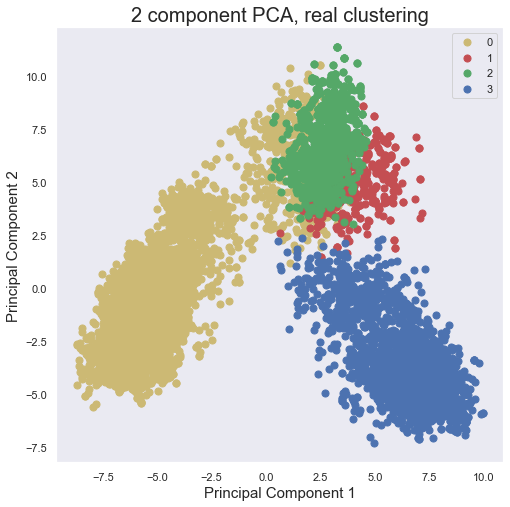

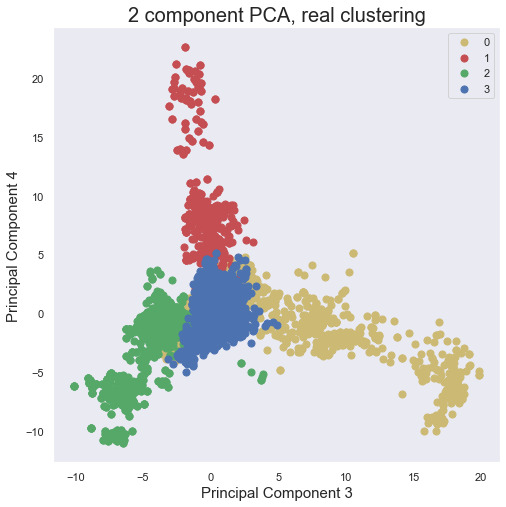

In [31]:
y_actual = np.array(list(df['Docker']))

graph_pca(X, y_actual, 'real clustering')

DBSCAN is attempted in place of kmeans but does very poorly

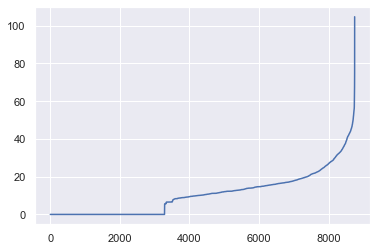

In [32]:
# Attempt DBSCAN rather than kmeans
# optimise epsilon for DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
#epsilon should be the point of greatest curvature 

db = DBSCAN(eps=30, min_samples=5).fit(X)
y_pred = db.labels_



[0.02801606 0.01710534 0.0119565  0.01014666]


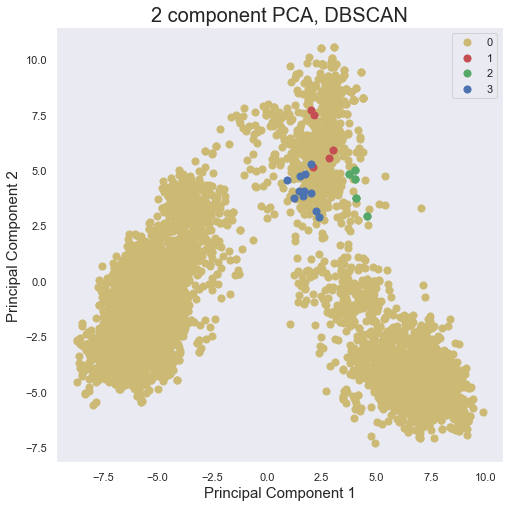

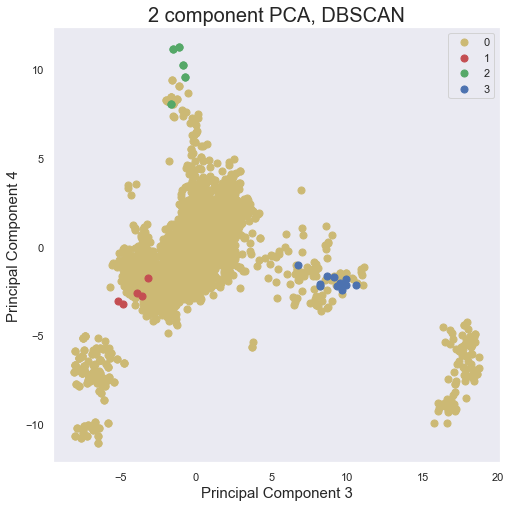

In [33]:
# Repeat PCA with DBSCAN (poor result)
graph_pca(X, y_pred, 'DBSCAN')

## Repeat with alternative jtnn-autoencoder feature set

The following section repeats all of the above processes but with the jtnn-autoencoder feature set as X in place of the Morgan fingerprints. 

In [34]:
feature = 'Feature'
df['Feat_list'] = df[feature].apply(str_to_list)

In [35]:
X = list(df['Feat_list'])
X = np.array(X)

y = np.array(list(df['Score']))


In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.fit_transform(X)


In [37]:
len(X)

8747

In [38]:
dfX = pd.DataFrame(X)
dfX['score'] = y

In [39]:
dfX.columns
dfX = dfX[dfX['score'] < 0]

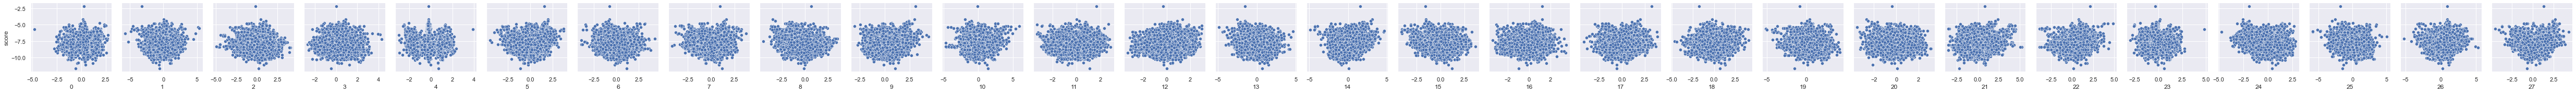

In [40]:
# every individual feature is plotted against the scoring (only 28 here as opposed to the 1024 for the Morgan),
# no obvious weird data behaviour

sns.pairplot(
    dfX,
    x_vars=[0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,],
    y_vars=["score"],
)

[0.17411116 0.14315889 0.12201306 0.08728465]


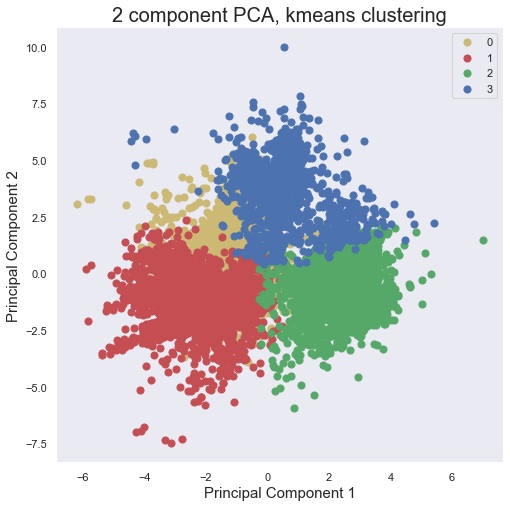

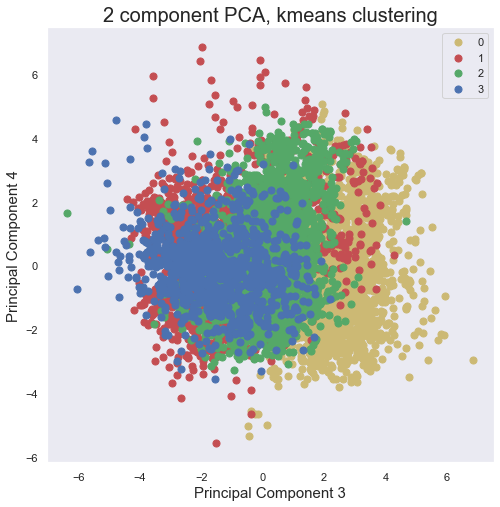

In [41]:
# More of the variance explained by the PCs with this more compact representation than with the Morgan fingerprint
y_pred = KMeans(n_clusters=4, random_state=0).fit_predict(X)
graph_pca(X, y_pred, 'kmeans clustering')

[0.17411116 0.1431589  0.12201306 0.08728495]


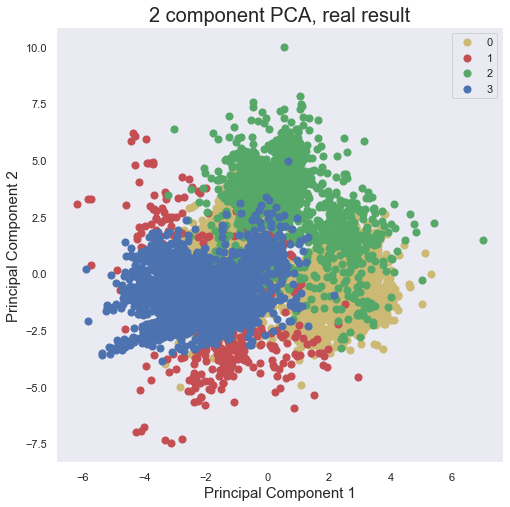

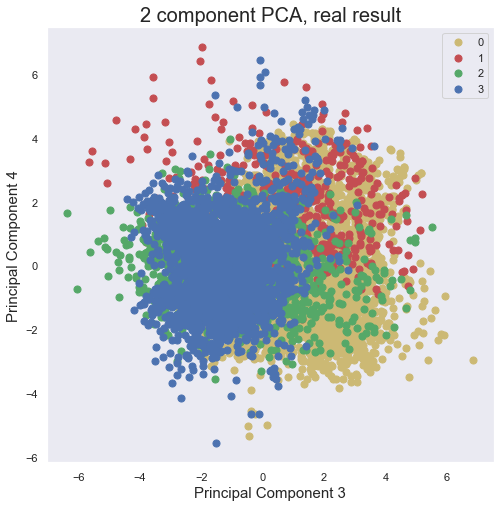

In [42]:
# Compare with real result, again kmeans can approximate some clustering which gives some encouragement for using
# this feature set in ML
y_actual = np.array(list(df['Docker']))
graph_pca(X, y_actual, 'real result')

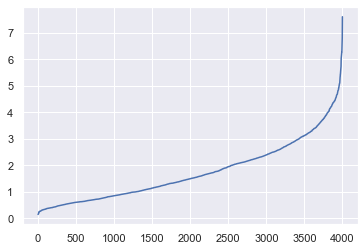

In [51]:
# optimise epsilon for dbscan
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
#epsilon should be the point of greatest curvature 


[0.17153772 0.14135173 0.12016944 0.08707784]


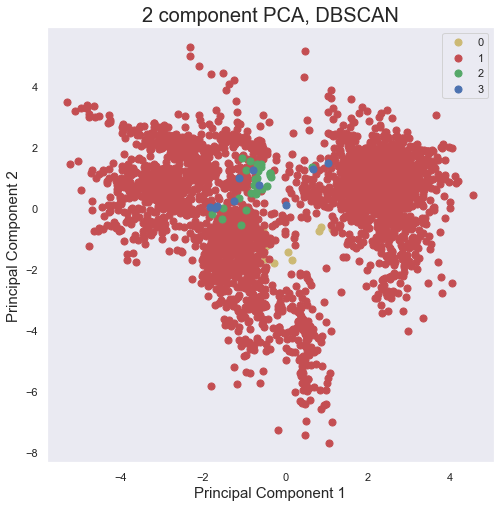

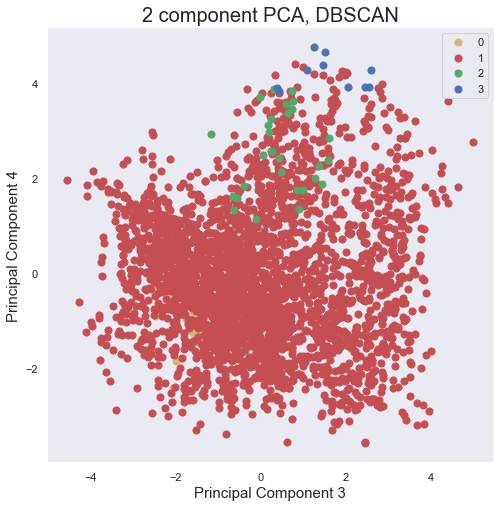

In [53]:
# Repeat PCA with DBSCAN (poor result)
db = DBSCAN(eps=3, min_samples=5).fit(X)
y_pred = db.labels_
graph_pca(X, y_pred, 'DBSCAN')

# Learning Curves

Try some models with the different representations

In [44]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel as C
from sklearn.naive_bayes import GaussianNB


# this function compares learning curves between different models


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [45]:
# The above function is quite demanding so only a subset (4000 molecules) of the dataset is used
# Morgan fingerprints investigated first

df = pd.read_csv('Data/Docker_Morgan_Fingerpint.csv')
df = df[df['Score'] < 0]
feature = 'Morgan'
df['Feat_list'] = df[feature].apply(str_to_list)

df_pred = df.sample(4000, random_state = 1)
X = np.array(list(df_pred['Feat_list']))
y = np.array(df_pred['Score'])

scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.fit_transform(X)

In [46]:
X.shape

(4000, 1024)

In [47]:
y.shape

(4000,)

The following graphs can be summarised as follows:
- The most important graphs are those in the top row giving the overall R2 score of the model with increasing training set size
- The lower 2 rows give information on how the model scales in terms of fit times (less relevant for this project given the small training set sizes)
- Naive Bayes fails to obtain any fit
- Gaussian Process (GP) regressor is designed to fit every point in the training set so its training score is perfect (the cross-validation score is more informative of performance)
- MLP obtains a fit but performs poorly
- None of these default implementations work particularly well but the GP appears to perform best in general, and works more effectively with jtnn-autoencoder features than Morgan fingerprints

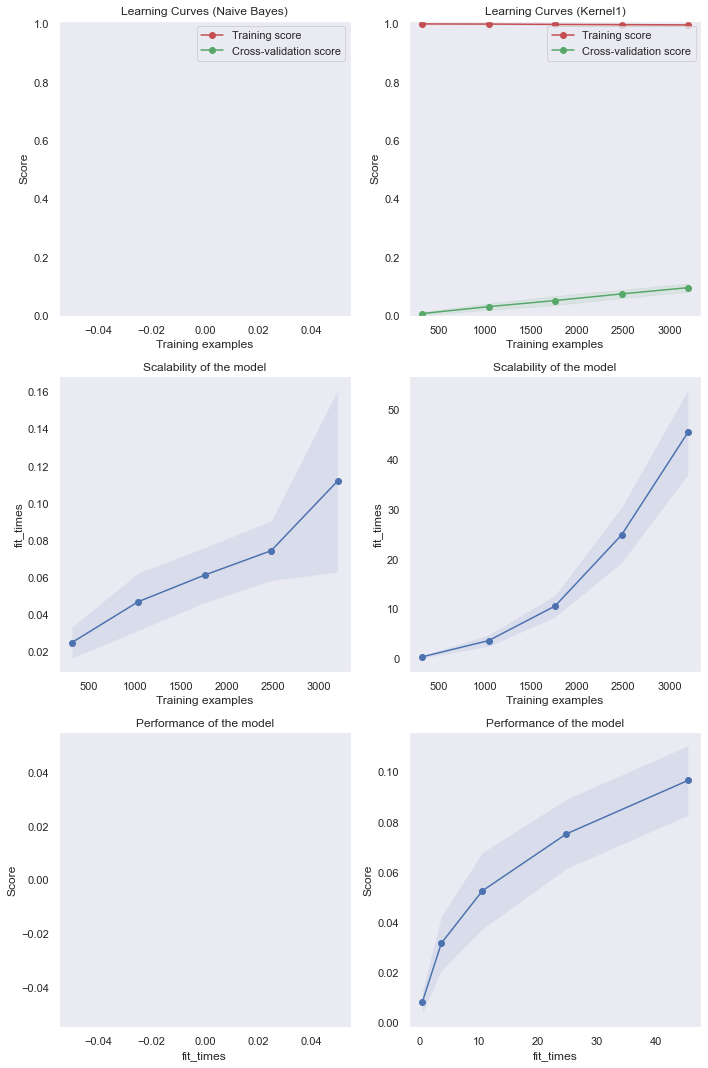

In [48]:
# Compare learning curves for a naive Bayes vs a generic Gaussian Process kernel using Morgan Fingerprints
# note: takes a few minutes!

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = r"Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves (Kernel1)"


kernel = C(1., 'fixed') * RBF(1., 'fixed')
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)

estimator = gp
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

plt.tight_layout()
plt.show()


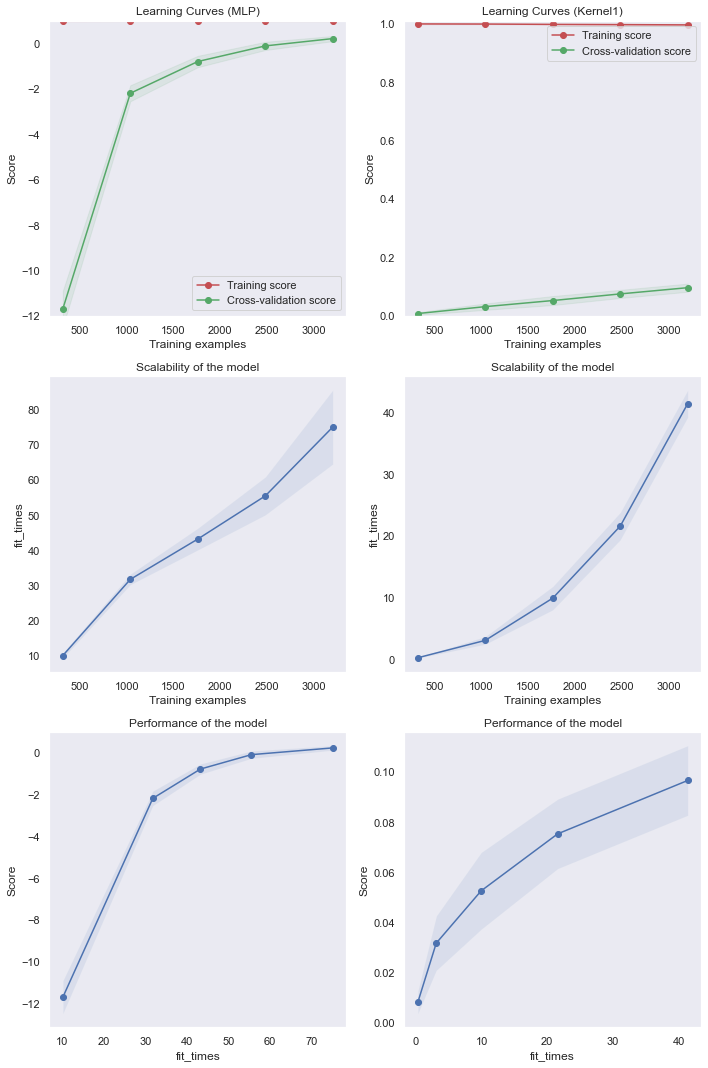

In [49]:
# Compare learning curves for a generic MLP vs a generic Gaussian Process kernel using Morgan Fingerprints
# note: takes a few minutes!

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Kernel1)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

kernel = C(1.0, 'fixed') * RBF(1., 'fixed')
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)

estimator = gp

plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (MLP)"
regr = MLPRegressor((500, 2), activation='relu',
                  # loss='mse',
                  solver='adam',
                  alpha=0.0001,
                  batch_size=500,
                  max_iter=100,
                  momentum=0.9,
                  nesterovs_momentum=True,
                  random_state=1)
estimator = regr


plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(-12, 1.01),
                    cv=cv, n_jobs=4)

plt.tight_layout()
plt.show()



In [55]:
# Now try the jtnn-autoencoder features
df = pd.read_csv('Data/Docker_Morgan_Fingerpint.csv')
df = df[df['Score'] < 0]
feature = 'Feature'
df['Feat_list'] = df[feature].apply(str_to_list)

df_pred = df.sample(4000, random_state = 1)
X = np.array(list(df_pred['Feat_list']))
y = np.array(df_pred['Score'])

scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.fit_transform(X)

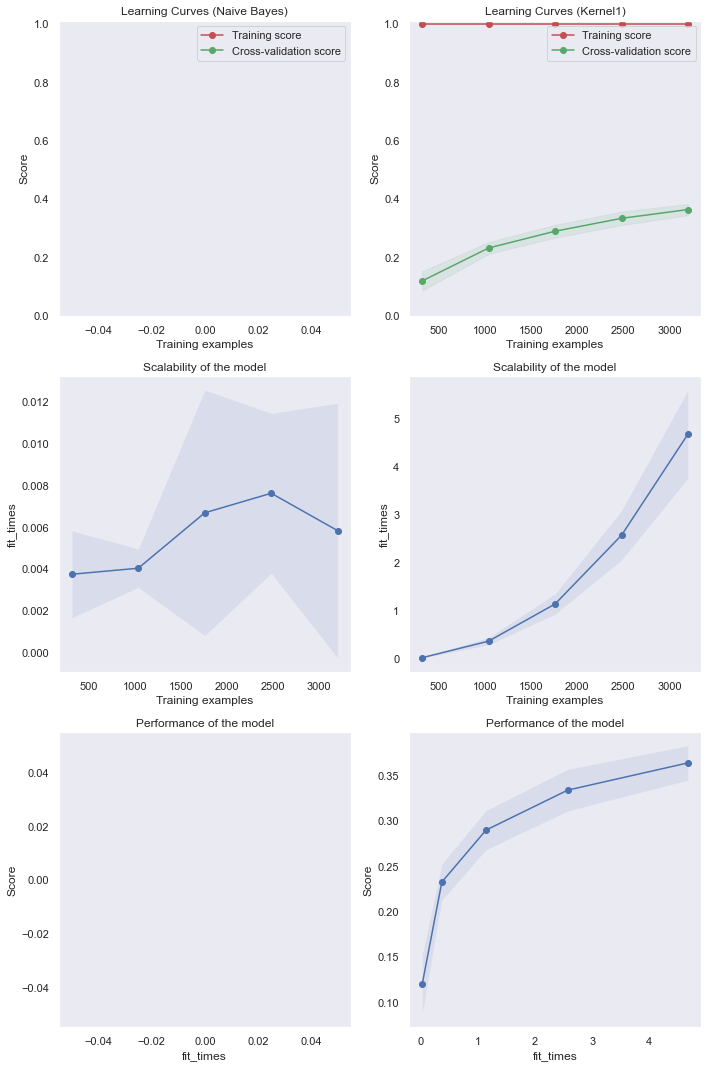

In [56]:
# Compare learning curves for a naive Bayes vs a generic Gaussian Process kernel using jtnn-autoencoder features
# note: takes a few minutes!

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = r"Learning Curves (Naive Bayes)"

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves (Kernel1)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

kernel = C(1.0, 'fixed') * RBF(1., 'fixed')
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)

estimator = gp
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

plt.tight_layout()
plt.show()


# note: Naive Bayes fails to obtain any fit

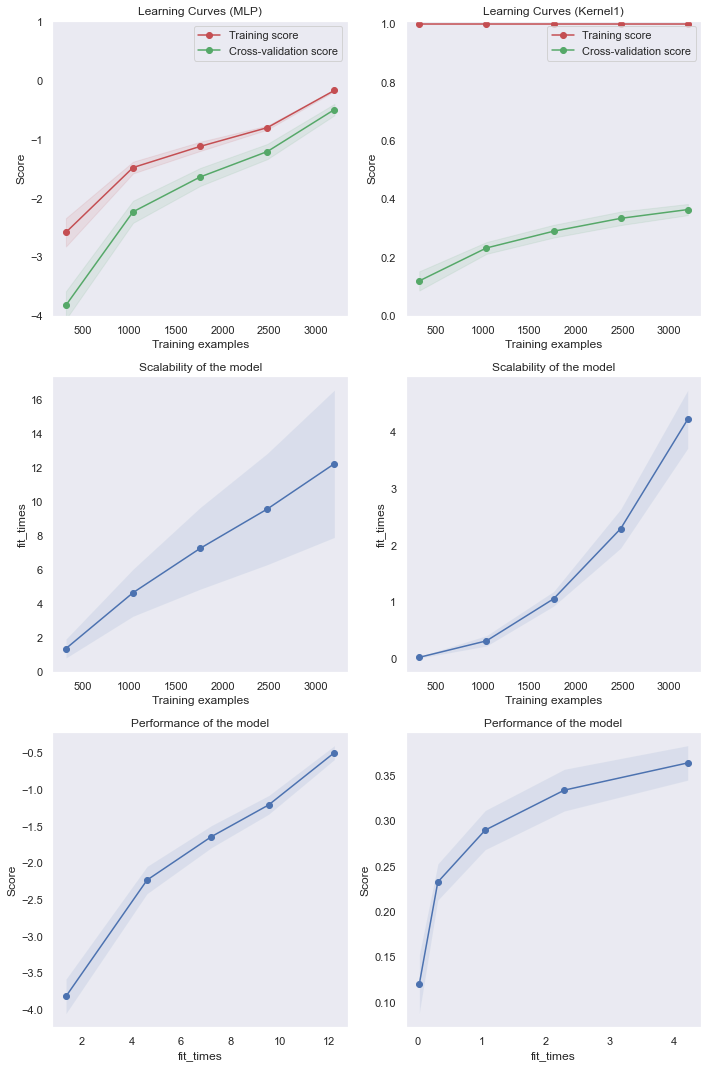

In [57]:
# Compare learning curves for a generic MLP vs a generic Gaussian Process kernel using jtnn-autoencoder features
# note: takes a few minutes!

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Kernel1)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

kernel = C(1.0, 'fixed') * RBF(1., 'fixed')
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)

estimator = gp

plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (MLP)"
regr = MLPRegressor((500, 2), activation='relu',
                  # loss='mse',
                  solver='adam',
                  alpha=0.0001,
                  batch_size=500,
                  max_iter=100,
                  momentum=0.9,
                  nesterovs_momentum=True,
                  random_state=1)
estimator = regr


plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(-4, 1.01),
                    cv=cv, n_jobs=4)

plt.tight_layout()
plt.show()



Model performance is quite poor across the board here but the main take aways are:
- the GP performs better than the other options 
- the jtnn-autoencoder features do better than Morgan fingerprints with thr GP

With some tuning of the GP kernel and the use of the uncertainty as a joint ranking metric with the predicted 
score, a model can predict molecules at the desired end of the distribution starting with very
small training sets (good for an early stage drug discovery setting)

In the scenario below I've taken the following steps:
1. Started off with 100 randomly sampled molecules as a training set for the model
2. Used the model to predict the best 100 molecules for binding based on both predicted value and the model's uncertainty in that prediction (the distribution of binding scores for those 100 molecules are shown in the boxplot; iteration 1)
3. Added the real score values for those 100 mols to the training set, removed them from the test set and repeated the whole process resulting in iteration 2 (another 100 mols predicted to be the best)
4. Continue to iterate expanding the training set at each stage and depleting the test set

At each stage the 100 mols are removed from the test set and added to the training set to mimic how I will experimentally test molecules and then add the real result to the training set, in an iterative loop of experimental testing and model improvement. The y axis has the binding score and the blue dotted line is the mean of the parent set at the start so anything below this line is an improvement over random sampling (note this is the starting mean, the actual test set mean gets worse, i.e. binding energy increases as more good binders are removed).

This can be repeated for many different random starting samples and the behaviour is the same on average.

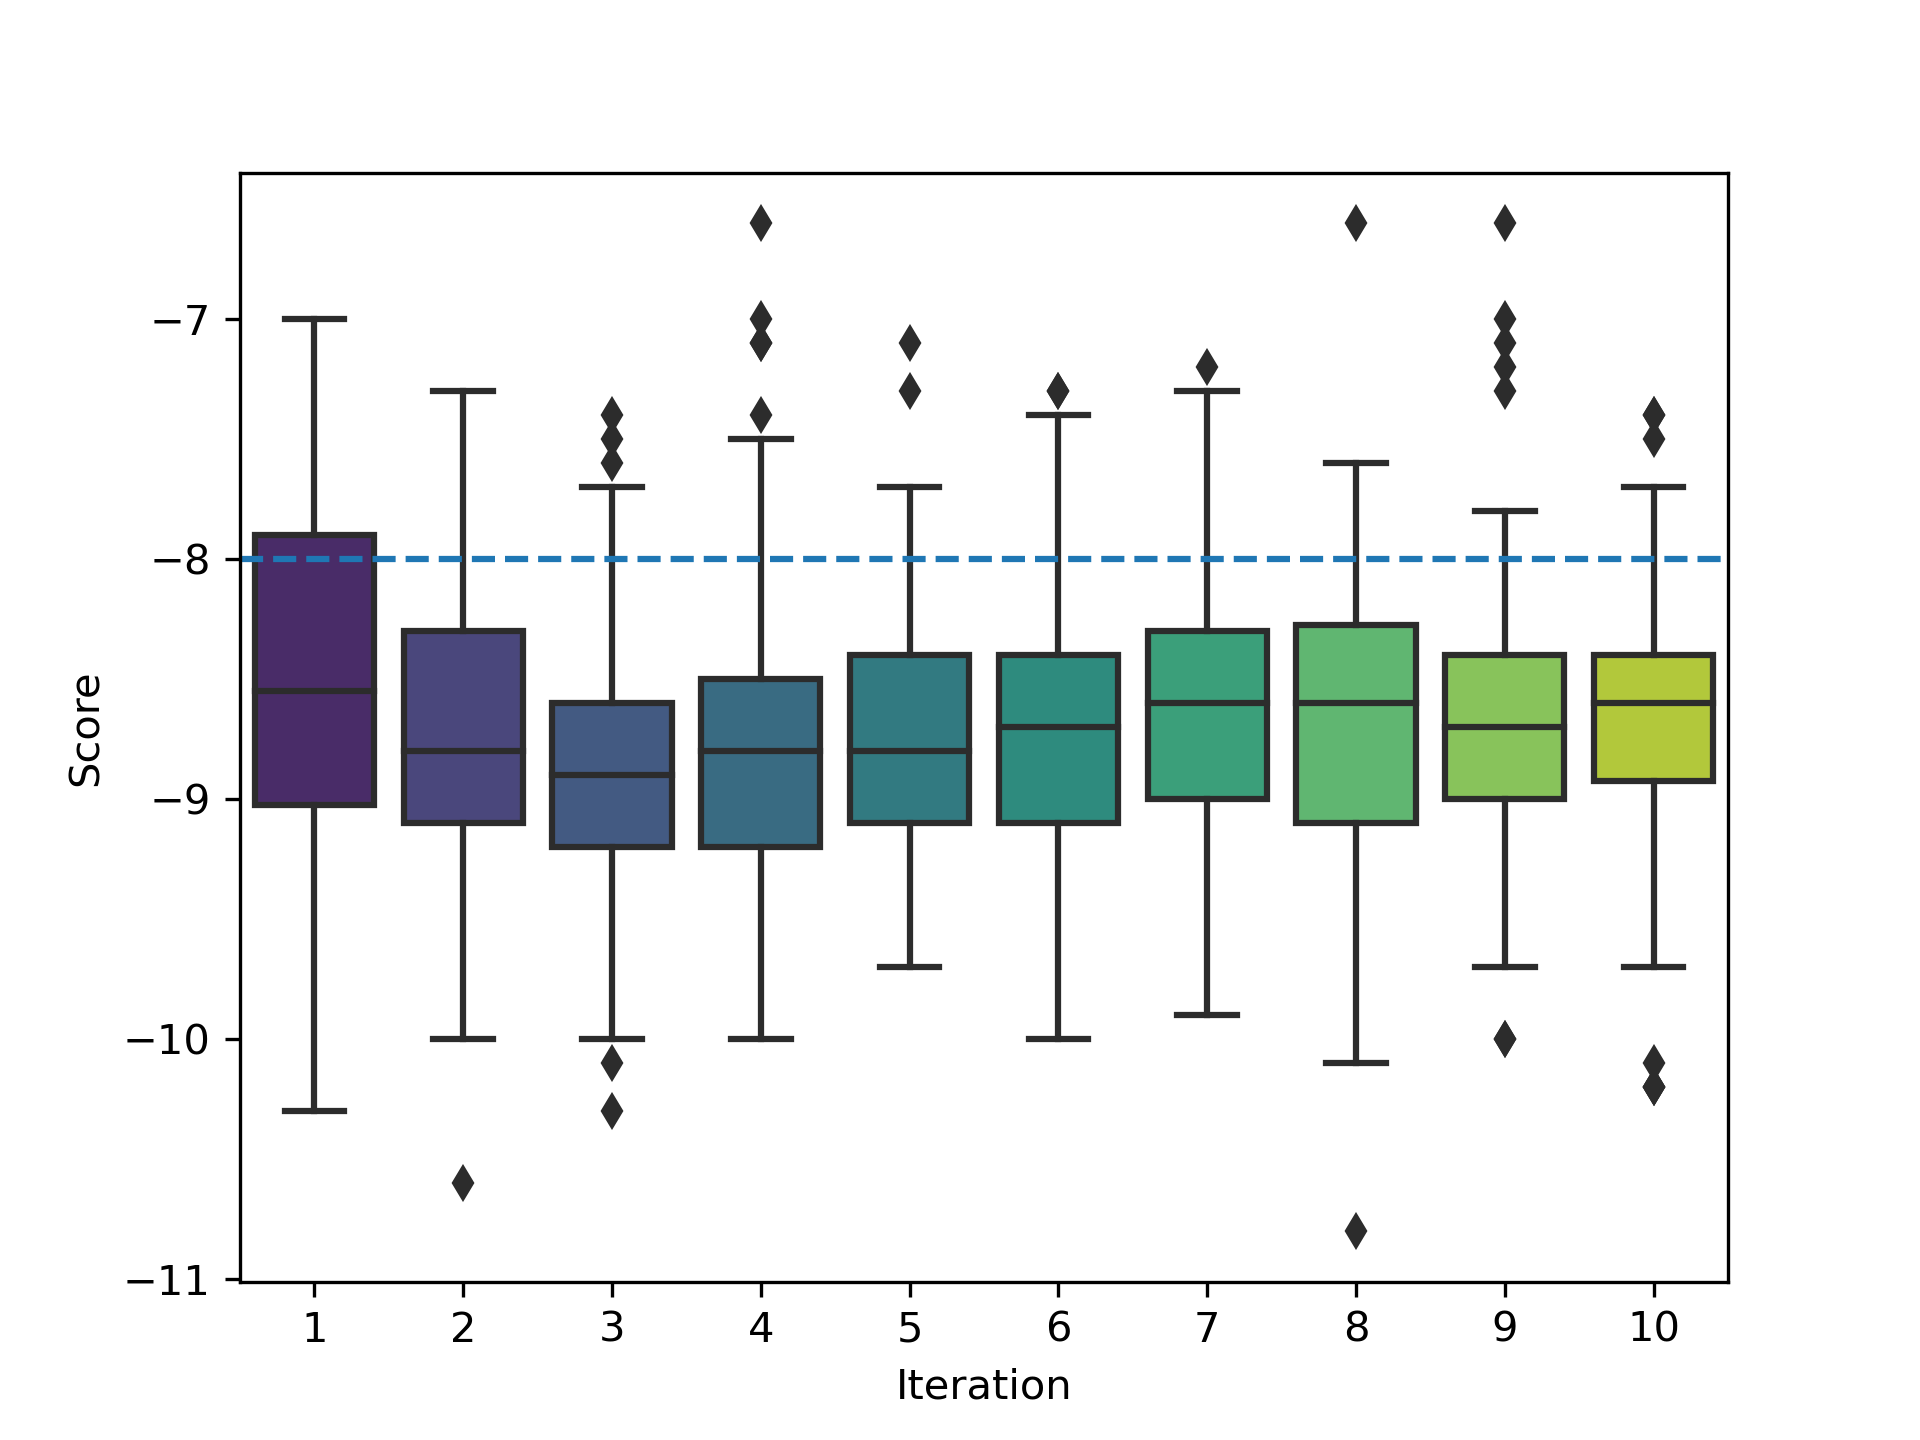

In [58]:
from IPython.display import Image 

Image("10 Score2.png")

8977 793


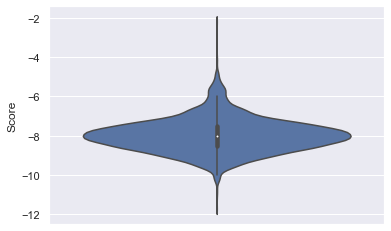

In [59]:
# Compare with original distribution, there are relatively few values below -9
sns.violinplot(y = 'Score', data = df)
print(len(df), len(df[df['Score']<-9]))